# Social Media APIs and Marketing

## 1. Google trends to predict Covid cases

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime, timedelta
from pytrends.request import TrendReq

*Google Flu Trends* was a web service operated by Google. It provided estimates of influenza activity for more than 25 countries. By aggregating Google Search queries, it attempted to make accurate predictions about flu activity. This project was first launched in 2008 by *Google.org* to help predict outbreaks of flu. *Google Flu Trends* stopped publishing current estimates on 9 August 2015. We can use the open access tool *Google Trends* to build a similar engine that can predict the daily number of Covid cases. Here, we take a first step, by identifying patterns between searches and cases.

**Loading a data set of daily Covid cases**

We start by analyzing daily Covid data with Google trends. Before getting into the Google API, we take data about daily cases from "Our World in Data", which is freely available <a href='https://github.com/owid/covid-19-data/tree/master/public/data'>here</a> (the site also recommends the below stable link).

In [2]:
df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
df.fillna(0,inplace=True)
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0


As always when working with dates, we want to make sure that our data is actually recognized as such (and not just a string), so we convert the `date` column.

In [4]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

Let's start with a specific location and time: Covid cases in the US between April 1, 2020, and December 1, 2020 (some more on the choice of date later). Therefore, continue by creating a new dataframe containing only the relevant data:

In [5]:
us_df = df[(df['date'] <= datetime(2020,12,1)) & (df['date'] >= datetime(2020,4,1)) & (df['iso_code'] == 'USA')]
us_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
120106,USA,North America,United States,2020-04-01,224281.0,32202.0,22205.714,6635.0,1276.0,752.714,...,19.1,24.6,0.0,2.77,78.86,0.926,0.0,0.00,0.00,0.000000
120107,USA,North America,United States,2020-04-02,256626.0,32345.0,24280.571,8146.0,1511.0,909.000,...,19.1,24.6,0.0,2.77,78.86,0.926,0.0,0.00,0.00,0.000000
120108,USA,North America,United States,2020-04-03,288993.0,32367.0,26248.571,9566.0,1420.0,1037.286,...,19.1,24.6,0.0,2.77,78.86,0.926,0.0,0.00,0.00,0.000000
120109,USA,North America,United States,2020-04-04,321379.0,32386.0,27708.857,11172.0,1606.0,1164.857,...,19.1,24.6,0.0,2.77,78.86,0.926,0.0,0.00,0.00,0.000000
120110,USA,North America,United States,2020-04-05,350713.0,29334.0,29595.571,12790.0,1618.0,1316.714,...,19.1,24.6,0.0,2.77,78.86,0.926,8029.5,0.96,26.19,24.118764


**Using Google Trends to find out about searches**

`pytrend`'s `TrendReq` connects us directly with the Google Trend API. We use `build_payload` to establish what we are looking for (keywords, location, timeframe, etc.), and can then call up different data, such as interest over time, interest by region, related topics, related queries, trending searches, top charts, suggestions, or categories. The full documentation is <a href="https://github.com/GeneralMills/pytrends">here</a>.

Let's start by getting `interest_over_time()` for the search "can't smell" during the same time frame as above. Note that, if you specify a time frame longer than 270 days, the API will return weekly results instead of daily ones!

In [6]:
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["can't smell"],timeframe='2020-04-01 2020-12-01', geo="US")
smell_trends = pytrend.interest_over_time()
smell_trends

,can't smell,isPartial
date,,
2020-04-01,49,False
2020-04-02,58,False
2020-04-03,49,False
2020-04-04,28,False
2020-04-05,28,False
...,...,...
2020-11-27,64,False
2020-11-28,87,False
2020-11-29,43,False


Note that `interest_over_time()` already generates a data frame. However, this is indexed by date, which can make merging a bit tricky. So instead of using that data frame, we create a new one with the same data.

In [7]:
smell_trends = pd.DataFrame(data = {'date': smell_trends.index.tolist(), 'search': smell_trends["can't smell"].tolist()})
smell_trends

,date,search
0,2020-04-01,49
1,2020-04-02,58
2,2020-04-03,49
3,2020-04-04,28
4,2020-04-05,28
...,...,...
240,2020-11-27,64
241,2020-11-28,87
242,2020-11-29,43
243,2020-11-30,56


Let's now take a look at the searches over time. Note that the "interest" returned by our query is relative to the peak interest within the query timeframe (so the maximum will always be 100).

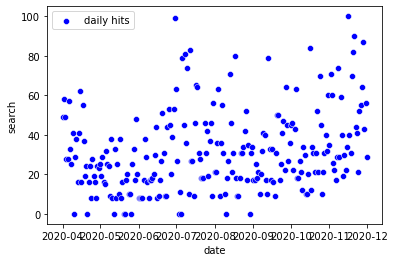

In [8]:
sns.scatterplot( x = 'date',
             y = 'search',
             data = smell_trends,
             label = 'daily hits', color="blue")
plt.show()

To get a better idea of what is happening, let's add a rolling weekly average (we can use `column.rolling(k)` where `k` is the number of entries). Note that this creates some `NA` values, because there is no rolling average for the first 6 days.

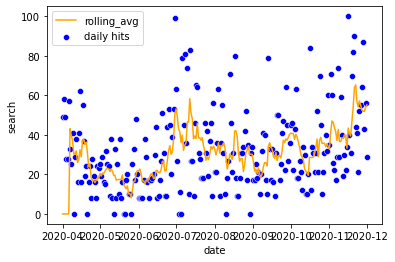

In [9]:
smell_trends['rolling_avg' ] = smell_trends.search.rolling(7).mean()
smell_trends = smell_trends.fillna(0)
sns.scatterplot( x = 'date',
             y = 'search',
             data = smell_trends,
             label = 'daily hits', color="blue")
sns.lineplot( x = 'date',
             y = 'rolling_avg',
             data = smell_trends,
             label = 'rolling_avg', color="orange")
plt.show()

In order to run a linear regression, all the data needs to be in a single dataframe. Consequently, we need to combine the Google trends data with the Covid data. This can be done seamlessly by merging the two dataframes into a new one using the command `.merge()` as follows:

In [22]:
combined_df = pd.merge(us_df,smell_trends,on="date")
combined_df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,search,rolling_avg
0,USA,North America,United States,2020-04-01,224281.0,32202.0,22205.714,6635.0,1276.0,752.714,...,0.0,2.77,78.86,0.926,0.0,0.00,0.00,0.000000,49,0.000000
1,USA,North America,United States,2020-04-02,256626.0,32345.0,24280.571,8146.0,1511.0,909.000,...,0.0,2.77,78.86,0.926,0.0,0.00,0.00,0.000000,58,0.000000
2,USA,North America,United States,2020-04-03,288993.0,32367.0,26248.571,9566.0,1420.0,1037.286,...,0.0,2.77,78.86,0.926,0.0,0.00,0.00,0.000000,49,0.000000
3,USA,North America,United States,2020-04-04,321379.0,32386.0,27708.857,11172.0,1606.0,1164.857,...,0.0,2.77,78.86,0.926,0.0,0.00,0.00,0.000000,28,0.000000
4,USA,North America,United States,2020-04-05,350713.0,29334.0,29595.571,12790.0,1618.0,1316.714,...,0.0,2.77,78.86,0.926,8029.5,0.96,26.19,24.118764,28,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,USA,North America,United States,2020-11-27,13226451.0,204936.0,169056.000,267106.0,1552.0,1588.000,...,0.0,2.77,78.86,0.926,0.0,0.00,0.00,0.000000,64,52.428571
241,USA,North America,United States,2020-11-28,13384075.0,157624.0,165735.429,268464.0,1358.0,1548.000,...,0.0,2.77,78.86,0.926,0.0,0.00,0.00,0.000000,87,52.000000
242,USA,North America,United States,2020-11-29,13524480.0,140405.0,164904.714,269515.0,1051.0,1546.571,...,0.0,2.77,78.86,0.926,351331.9,13.14,29.28,1055.319892,43,51.857143
243,USA,North America,United States,2020-11-30,13681218.0,156738.0,162556.286,270827.0,1312.0,1580.714,...,0.0,2.77,78.86,0.926,0.0,0.00,0.00,0.000000,56,54.000000


**Combining cases and searches graphically**

Next, we plot the two time series together, to see if we can spot a pattern. Note that the scales are vastly different, so it pays off to create a graph with multiple scales.

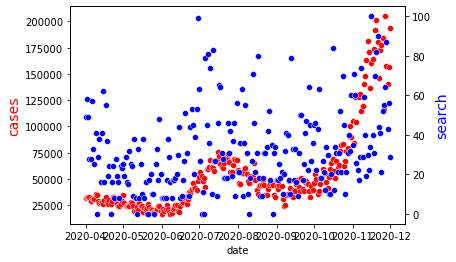

In [11]:
ax = sns.scatterplot(x=combined_df.date, y=combined_df.new_cases, color = "red")
ax.set_ylabel("cases",color="red",fontsize=14)
ax2 = plt.twinx()
sns.scatterplot(x=combined_df.date, y=combined_df.search, color = "blue")
ax2.set_ylabel("search",color="blue",fontsize=14)
plt.show()

**Estimating the relationship between searches and cases**

We can start with a simple regression of the daily cases on the searches

In [12]:
X = sm.add_constant(combined_df.search)
model = sm.OLS(combined_df.new_cases, X)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:              new_cases   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     38.81
Date:                Thu, 28 Oct 2021   Prob (F-statistic):           2.04e-09
Time:                        11:28:05   Log-Likelihood:                -2934.1
No. Observations:                 245   AIC:                             5872.
Df Residuals:                     243   BIC:                             5879.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.225e+04   4519.593      7.136      0.0

/opt/anaconda3/envs/smm750/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


We can probably find a better model than that. For example, there is a lot of noise, so we may want to smooth out the data. Let's try using the rolling weekly average of cases that we added in before.

In [13]:
X = sm.add_constant(combined_df.rolling_avg)
model = sm.OLS(combined_df.new_cases, X)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:              new_cases   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     202.7
Date:                Thu, 28 Oct 2021   Prob (F-statistic):           7.51e-34
Time:                        11:28:07   Log-Likelihood:                -2878.0
No. Observations:                 245   AIC:                             5760.
Df Residuals:                     243   BIC:                             5767.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -1.68e+04   5466.956     -3.072      

/opt/anaconda3/envs/smm750/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Exercise 1:

Try increasing the predictive power of this method even further. There could be a lag between intial symptoms and an eventual test - we can created lagged variables using `column.shift(k)` where `k` is the number of observations by which the column is shifted downward (e.g., if `k=7`, the "search" data from day 1 is now in the new column at day 8). Of course, there are no values to shift in anywhere before observation `k`, so don't forget to deal with `NA` values.

In [52]:
combined_df = pd.merge(us_df,smell_trends,on="date")

days = 14
combined_df['shifted_search'] = combined_df.search.shift(days)
combined_df['shifted_rolling_avg'] = combined_df.rolling_avg.shift(days)
combined_df.fillna(0,inplace=True)
# combined_df.tail()

Run the model with the right columns for the `X` variable:

In [50]:
X = sm.add_constant(combined_df.shifted_rolling_avg)
model = sm.OLS(combined_df.new_cases, X)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:              new_cases   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     78.99
Date:                Thu, 28 Oct 2021   Prob (F-statistic):           1.44e-16
Time:                        12:21:30   Log-Likelihood:                -2917.8
No. Observations:                 245   AIC:                             5840.
Df Residuals:                     243   BIC:                             5847.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                9375.2272   5

/opt/anaconda3/envs/smm750/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


What do you see?

### Exercise 2:

Let's explore another country: check both of the search terms "smell" and "fever" for the United Kingdom (`geo="GB"`), for the timeframe January 1, 2020 to May 1, 2020 (`'2020-01-01 2020-05-01'`).

In [46]:
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["can't smell",'fever'],timeframe='2020-01-01 2020-05-01', geo="GB")
gb_trends = pytrend.interest_over_time()
# gb_trends
gb_trends = pd.DataFrame(data = {'date': gb_trends.index.tolist(), 
                                 'smell_search': gb_trends["can't smell"].tolist(),
                                 'fever_search': gb_trends["fever"].tolist()})

gb_trends.head()

,date,smell_search,fever_search
117,2020-04-27,0,27
118,2020-04-28,0,28
119,2020-04-29,0,32
120,2020-04-30,0,21
121,2020-05-01,0,24


In [48]:
gb_trends.describe()

,smell_search,fever_search
count,122.000000,122.000000
mean,0.155738,35.786885
std,0.406974,17.688877
min,0.000000,18.000000
25%,0.000000,23.000000
50%,0.000000,29.000000
75%,0.000000,45.250000
max,2.000000,100.000000


Try to plot the patterns of both columns in a single plot (e.g., using `seaborn`). What about differences do you see in those patterns?

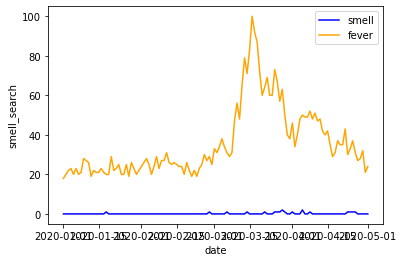

In [51]:
sns.lineplot( x = 'date',
             y = 'smell_search',
             data = gb_trends,
             label = 'smell', color="blue")
sns.lineplot( x = 'date',
             y = 'fever_search',
             data = gb_trends,
             label = 'fever', color="orange")
plt.show()

### Discussion point: what could this type of data be helpful for in a buisness setting?

## 2. Measuring engagement

Let's use our newfound skills with the Google trends API to measure enagagement following a marketing campaign. The company Red Bull spends a large sum of money on its Formula 1 team, in order to market its brand. But it also does lots of other marketing activities. Because most people don't go to the supermarket to buy a Red Bull drink after watching a Formula 1 event, it can be quite tricky to associate sales with different marketing campaigns. But social media allows us to capture consumer reactions and engagement in real time! So if we know that consumer engagement leads to more sales (at least, on the long term), it can be extremely valuable to measure engagement following marketing campaigns.

Our question will be twofold:
1. Does Red Bull create engagement with its Formula 1 expenditures?
2. Does the Pilot matter? I.e., is engagement related to success?

We start by pulling Google trends data for the search term "red bull" between March and yesterday (the Formula 1 season started at the end of March)

In [53]:
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["red bull"],timeframe='2021-03-01 2021-10-28')
trends = pytrend.interest_over_time()
trends

,red bull,isPartial
date,,
2021-03-01,32,False
2021-03-02,34,False
2021-03-03,38,False
2021-03-04,35,False
2021-03-05,30,False
...,...,...
2021-10-21,44,False
2021-10-22,40,False
2021-10-23,46,False


Note: Google Trends only gives us data about searches up to approx. three days ago.

As before, we want to clean up the dataset a bit:

In [54]:
trendsdf = pd.DataFrame(data = {'date': trends.index.tolist(),
                                'search': trends["red bull"].tolist()})
trendsdf

,date,search
0,2021-03-01,32
1,2021-03-02,34
2,2021-03-03,38
3,2021-03-04,35
4,2021-03-05,30
...,...,...
234,2021-10-21,44
235,2021-10-22,40
236,2021-10-23,46
237,2021-10-24,72


Don't forget to convert the date string to an actual Date object:

In [55]:
trendsdf['date'] = pd.to_datetime(trendsdf['date'])

Next, we take a look at the daily search hits (recall that the maximum will always be 100 in any Google Trends query):

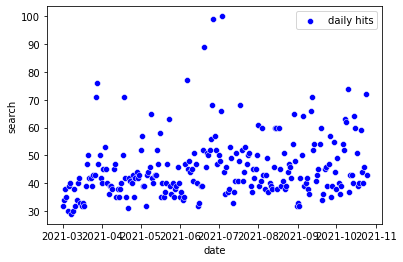

In [56]:
sns.scatterplot( x = 'date',
             y = 'search',
             data = trendsdf,
             label = 'daily hits', color="blue")
plt.show()

We have some data on the searches. Now, we can add race data into the mix (you can find the csv on Moodle):

In [57]:
racingdf = pd.read_csv('red_bull_race_results.csv')
racingdf

,date,perez,verstappen
0,28.03.21,5.0,2.0
1,18.04.21,11.0,1.0
2,02.05.21,4.0,2.0
3,09.05.21,5.0,2.0
4,23.05.21,4.0,1.0
5,06.06.21,1.0,18.0
6,20.06.21,3.0,1.0
7,27.06.21,4.0,1.0
8,04.07.21,6.0,1.0
9,18.07.21,16.0,NaN


Make sure that our dates are actual dates:

In [59]:
racingdf['date'] = pd.to_datetime(racingdf['date'], format="%d.%m.%y")
racingdf

,date,perez,verstappen
0,2021-03-28,5.0,2.0
1,2021-04-18,11.0,1.0
2,2021-05-02,4.0,2.0
3,2021-05-09,5.0,2.0
4,2021-05-23,4.0,1.0
5,2021-06-06,1.0,18.0
6,2021-06-20,3.0,1.0
7,2021-06-27,4.0,1.0
8,2021-07-04,6.0,1.0
9,2021-07-18,16.0,NaN


The dataset gives the positioning of the two Red Bull pilots, Sergio Pérez and Max Verstappen. A missing value indicates that the pilot did not finish the race.

Similar to before, we can merge the two data frames by date, in order to understand whether race day implies a high number of searches. For simplicity, we can take only one extra column of `racingdf`, to see whether the date exists or not.

In [60]:
temp = pd.merge(trendsdf, racingdf[['date','perez']], how='left',on='date')
temp

,date,search,perez
0,2021-03-01,32,NaN
1,2021-03-02,34,NaN
2,2021-03-03,38,NaN
3,2021-03-04,35,NaN
4,2021-03-05,30,NaN
...,...,...,...
234,2021-10-21,44,NaN
235,2021-10-22,40,NaN
236,2021-10-23,46,NaN
237,2021-10-24,72,3.0


Whereever there is a missing value in the `perez` column, there was no race on the day. We can adjust our dataframe accordingly:

In [61]:
temp['raceday'] = temp['perez'].notna()
temp

,date,search,perez,raceday
0,2021-03-01,32,NaN,False
1,2021-03-02,34,NaN,False
2,2021-03-03,38,NaN,False
3,2021-03-04,35,NaN,False
4,2021-03-05,30,NaN,False
...,...,...,...,...
234,2021-10-21,44,NaN,False
235,2021-10-22,40,NaN,False
236,2021-10-23,46,NaN,False
237,2021-10-24,72,3.0,True


It's time to plot our merged result:

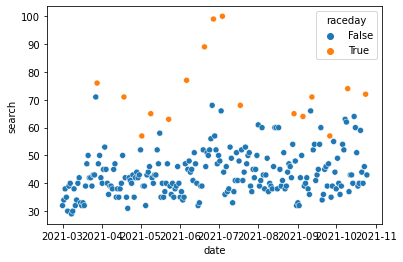

In [62]:
sns.scatterplot( x = 'date',
             y = 'search',
             data = temp,
            hue="raceday")
plt.show()

A first look at the data seems to indicate that there is support for the hypothesis that the Formula 1 marketing leads to customer engagement. Of course, more work is needed to establish robust evidence.

However, we will turn to the second question instead (whether the pilots matter). For this, we need to first clean the racing dataset.

Since disqualification is often a topic of intense interest in Formula 1, we create an additional column to measure whether a driver has not completed the race.

In [64]:
racingdf['perez_out'] = racingdf['perez'].isna().astype(int)
racingdf['verstappen_out'] = racingdf['verstappen'].isna().astype(int)
racingdf

,date,perez,verstappen,perez_out,verstappen_out
0,2021-03-28,5.0,2.0,0,0
1,2021-04-18,11.0,1.0,0,0
2,2021-05-02,4.0,2.0,0,0
3,2021-05-09,5.0,2.0,0,0
4,2021-05-23,4.0,1.0,0,0
5,2021-06-06,1.0,18.0,0,0
6,2021-06-20,3.0,1.0,0,0
7,2021-06-27,4.0,1.0,0,0
8,2021-07-04,6.0,1.0,0,0
9,2021-07-18,16.0,NaN,0,1


There is one special case, which requires contextual knowledge: on 2021-06-06, Verstappen did not finish the race and was only placed because he had completed more than 90%. For consistency, we may consider putting a 1 in the column `'verstappen_out'` here (this is a typical case in which you want to check for consistency)

In [65]:
racingdf.loc[racingdf['date'] == '2021-06-06','verstappen_out'] = 1

We then remove the `NAs` by replacing them with the worst result (this is of course just one possible choice and requires further analysis).

In [66]:
racingdf['perez'] = racingdf['perez'].fillna(racingdf['perez'].max())
racingdf['verstappen'] = racingdf['verstappen'].fillna(racingdf['verstappen'].max())
racingdf

,date,perez,verstappen,perez_out,verstappen_out
0,2021-03-28,5.0,2.0,0,0
1,2021-04-18,11.0,1.0,0,0
2,2021-05-02,4.0,2.0,0,0
3,2021-05-09,5.0,2.0,0,0
4,2021-05-23,4.0,1.0,0,0
5,2021-06-06,1.0,18.0,0,1
6,2021-06-20,3.0,1.0,0,0
7,2021-06-27,4.0,1.0,0,0
8,2021-07-04,6.0,1.0,0,0
9,2021-07-18,16.0,18.0,0,1


Next, we want to find out the search results around the race days. We start with an example, by taking the first race day:

In [67]:
race_date = racingdf.loc[0,'date']
race_date

Timestamp('2021-03-28 00:00:00')

We now define a time difference, between the race date and the date of searches:

In [68]:
trendsdf['difftime'] = trendsdf['date']-race_date
trendsdf

,date,search,difftime
0,2021-03-01,32,-27 days
1,2021-03-02,34,-26 days
2,2021-03-03,38,-25 days
3,2021-03-04,35,-24 days
4,2021-03-05,30,-23 days
...,...,...,...
234,2021-10-21,44,207 days
235,2021-10-22,40,208 days
236,2021-10-23,46,209 days
237,2021-10-24,72,210 days


We want this time difference to be in days, but as a number. For this, we use the `.days` attribute of the time difference:

In [69]:
trendsdf['difftime'] = [diff.days for diff in trendsdf['difftime']]
trendsdf

,date,search,difftime
0,2021-03-01,32,-27
1,2021-03-02,34,-26
2,2021-03-03,38,-25
3,2021-03-04,35,-24
4,2021-03-05,30,-23
...,...,...,...
234,2021-10-21,44,207
235,2021-10-22,40,208
236,2021-10-23,46,209
237,2021-10-24,72,210


Finally, we want to focus on the trends results 3 days before and after the race:

In [70]:
racetrends = trendsdf[abs(trendsdf['difftime']) <= 3]
racetrends

,date,search,difftime
24,2021-03-25,43,-3
25,2021-03-26,43,-2
26,2021-03-27,71,-1
27,2021-03-28,76,0
28,2021-03-29,47,1
29,2021-03-30,50,2
30,2021-03-31,42,3


Because overall trends may vary all the time for a number of factors, we focus on measuring the race day searches compared to the lowest search number in the week around the race:

In [71]:
min(racetrends['search'])

42

In [72]:
racetrends[racetrends['difftime']==0].iloc[0]['search']

76

In [73]:
racetrends[racetrends['difftime']==0].iloc[0]['search']/min(racetrends['search'])

1.8095238095238095

Let's put it all together and create an `"engagement"` column in our `racingdf`. In particular, we go through all the race dates and find the engagement (race day searches relative to lowest search number in the week).

In [74]:
relative_engagement = []
for i in range(len(racingdf)):
    race_date = racingdf.iloc[i,]['date']
    trendsdf['difftime'] = trendsdf['date']-race_date
    trendsdf['difftime'] = [diff.days for diff in trendsdf['difftime']]
    racetrends = trendsdf[abs(trendsdf['difftime']) <= 3]
    if len(racetrends[racetrends['difftime']==0]) > 0:
        relative_engagement.append( racetrends[racetrends['difftime']==0].iloc[0]['search']/min(racetrends['search']) )
    else:
        relative_engagement.append(np.nan)
racingdf['engagement'] = relative_engagement
racingdf

,date,perez,verstappen,perez_out,verstappen_out,engagement
0,2021-03-28,5.0,2.0,0,0,1.809524
1,2021-04-18,11.0,1.0,0,0,2.290323
2,2021-05-02,4.0,2.0,0,0,1.781250
3,2021-05-09,5.0,2.0,0,0,1.625000
4,2021-05-23,4.0,1.0,0,0,1.750000
5,2021-06-06,1.0,18.0,0,1,2.264706
6,2021-06-20,3.0,1.0,0,0,2.282051
7,2021-06-27,4.0,1.0,0,0,2.106383
8,2021-07-04,6.0,1.0,0,0,2.777778
9,2021-07-18,16.0,18.0,0,1,1.658537


Finally, recall that Google Trends only gives us search data until three days ago. Hence, we should cut out the latest race to avoid bias.

In [75]:
racingdf_short = racingdf.drop(racingdf.tail(1).index)
racingdf_short

,date,perez,verstappen,perez_out,verstappen_out,engagement
0,2021-03-28,5.0,2.0,0,0,1.809524
1,2021-04-18,11.0,1.0,0,0,2.290323
2,2021-05-02,4.0,2.0,0,0,1.781250
3,2021-05-09,5.0,2.0,0,0,1.625000
4,2021-05-23,4.0,1.0,0,0,1.750000
5,2021-06-06,1.0,18.0,0,1,2.264706
6,2021-06-20,3.0,1.0,0,0,2.282051
7,2021-06-27,4.0,1.0,0,0,2.106383
8,2021-07-04,6.0,1.0,0,0,2.777778
9,2021-07-18,16.0,18.0,0,1,1.658537


Now that we have the data, we can try to see what effects the placements have on engagement. Of course, we also analyze the effect of a driver not finishing the race:

In [76]:
X = racingdf_short.drop(['date', 'engagement'], axis=1)
Y = racingdf_short.engagement
X = sm.add_constant(X)
lm = sm.OLS(Y,X).fit()
print (lm.summary()) 

                            OLS Regression Results                            
Dep. Variable:             engagement   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     2.839
Date:                Thu, 28 Oct 2021   Prob (F-statistic):             0.0767
Time:                        12:42:39   Log-Likelihood:                 1.5400
No. Observations:                  16   AIC:                             6.920
Df Residuals:                      11   BIC:                             10.78
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.7938      0.279     10.

/opt/anaconda3/envs/smm750/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/envs/smm750/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


### Discussion point: Can you interpret these results? What do they indicate in terms of our second question? Why are the effect sizes different for the different drivers?

## 3. Interlude: Using Twitter data

It might be useful to also see what users are tweeting about regarding the races. Let's take a look at the Twitter API!

In [ ]:
import tweepy
import pickle

With the Twitter API we can access most of Twitter’s functionality from within Python (that means both reading **and** writing Tweets, or finding out about users and trends). The package of choice is *Tweepy*, which deals with all the messy details.

To access the Twitter API, you need to be authenticated. Hence, every request has to come with authentication information. To get this information in the first place, we need to generate our own credentials with a Developer Account:

1. Go to the <a href=https://developer.twitter.com/en>Twitter Developer Site</a> and apply for a Developer Account (you will need a Twitter account for this).
2. Create an application (e.g., "My_first_application"). Credentials and limits are per application, not per account.
3. Once you have created your application, you can transfer your consumer API key and secret, as well as your app access key and secret to the Python code below (see also https://developer.twitter.com/en/docs/basics/authentication/overview/oauth)

You can directly add your data as a string like this:
```
CONSUMER_API_KEY = 'COPY STRING HERE'
CONSUMER_API_SECRET = 'COPY STRING HERE'
ACCESS_KEY = 'COPY STRING HERE'
ACCESS_SECRET = 'COPY STRING HERE'
```

So that I can share my code without everyone using my credentials (which would probably lead to me being blocked by Twitter), I'm instead reading the data from a csv here:

In [ ]:
api_access = pd.read_csv('API_access.csv',delimiter=';')
CONSUMER_API_KEY = api_access[api_access['api'] == 'twitter_consumer_api_key']['key'].tolist()[0]
CONSUMER_API_SECRET = api_access[api_access['api'] == 'twitter_consumer_api_secret']['key'].tolist()[0]
ACCESS_KEY = api_access[api_access['api'] == 'twitter_access_key']['key'].tolist()[0]
ACCESS_SECRET = api_access[api_access['api'] == 'twitter_access_secret']['key'].tolist()[0]

We are also not allowed to request too many Tweets at the same time. There are per-day limits, as well as "rate limits" for 15-minute blocks. If you exceed your limits, you **will** get blocked for some time. For detailed information on the limits, check out https://developer.twitter.com/en/docs/twitter-api/v1/tweets/timelines/overview and https://developer.twitter.com/en/docs/rate-limits.
In many cases, we can use the functionality of Tweepy to automatically delay calls in order to wait on the rate limit - but be aware that this doesn't always work, and we may need to manually add timeouts.

We are now ready to create our verified interface (automatically waiting on our rate limit as necessary):

In [ ]:
auth = tweepy.OAuthHandler(CONSUMER_API_KEY, CONSUMER_API_SECRET)
auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)
api = tweepy.API(auth, wait_on_rate_limit = True)

Let's download some tweets! Note that the API only allows you to download tweets based on general queries from the past 9 days. If you want to download older tweets, you will need to dowload the tweets of a particular account (see below). For simplicity, we will focus on the last week.

In [ ]:
start_day = datetime.utcnow() - timedelta(days=7)
start_day

We can make a simple query such as `q="bayes"`. However, can you see why this could lead to problems?

Luckily, we can simply combine keywords with `OR` and `AND`.

In [ ]:
tweets = []
for tweet in tweepy.Cursor(api.search,q="bayes AND business AND school",
                           include_rts=True,lang="en",since=str(start_day.date())).items():
    tweets.append(tweet)

Here, `include_rts` specifies whether we are also including retweets, and `lang` specifies the language of tweets we request. Let's take a look at our tweets, as well as some of the basic information about them. You can find details about the tweet objects at https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet.

In [ ]:
for tweet in tweets:
    print("Created at: " + str(tweet.created_at))
    print("User: " + tweet.user.screen_name)
    print("Followers: " + str(tweet.user.followers_count))
    print("Content: " + tweet.text)
    print("---------------------\n")

### Exercise 3:

Repeat the query above, searching for tweets with the hashtag #bayes without date limitations:

## 4. Finding Red bull tweets

Let's go back to Red Bull, and search for tweets with the hash tag `"#redbull"`.

Note: in principle, the `include_rts=False` option should exclude any retweets. In practice, however, there seems to be some issues in how `tweepy` performs this exclusion. Hence, we make sure manually to only capture original tweets, using the keyworkd `"-filter:retweets"` in our query.

In [ ]:
tweets = []
for tweet in tweepy.Cursor(api.search,q="#redbull -filter:retweets",
                           lang="en",since=str(start_day.date())).items():
    tweets.append(tweet)
len(tweets)

A side note: When requesting tweets in this manner, the API will cut anything beyond 140 characters. That means, even if we search for tweets with #redbull, the tweet we receive may not contain the hashtag. However, we can
- "Hydrate" tweets at any time, using just their ID (i.e. request the full text). You can thus use only the tweet ID to share your data
- add the parameter `tweet_mode='extended'` to our `tweepy.Cursor()` call. In this case, returned tweets no longer have a `.text` attribute, but a `.full_text` attribute 

Let's start having a look at Tweeter demographics. Where are tweeters from (we only consider accounts with locations)? Remember, that the <a href="https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet">Developer Platform</a> has all the relevant information about tweet objects.

In [ ]:
tweet = tweets[0]
tweet.user.location

In [ ]:
tweet_loc = [tweet.user.location for tweet in tweets if tweet.user.location != ""]
len(tweet_loc)

We will consider only locations that have at least 5 tweets emerging from them.

In [ ]:
tweet_loc_df = pd.DataFrame(tweet_loc,columns=['location'])
tweet_loc_df = tweet_loc_df.groupby('location')['location'].count().reset_index(name='count')
tweet_loc_df = tweet_loc_df[tweet_loc_df['count'] >= 5]
tweet_loc_df.sort_values(by='count',ascending=False)

Do you see a possible problem here?

Let's now take a look at when the Tweets where sent.

In [ ]:
tweet.created_at.date()

In [ ]:
tweet.created_at.date().day

We can collect the counts per day into a table:

In [ ]:
tweet_day = [tweet.created_at.date().day for tweet in tweets]
tweet_day_df = pd.DataFrame(tweet_day,columns=['day'])
tweet_day_df = tweet_day_df.groupby('day')['day'].count().reset_index(name='count')
tweet_day_df

Let's see this graphically:

In [ ]:
sns.lineplot(y=tweet_day_df['count'], x = tweet_day_df['day'])
plt.show()

The variation seems familiar, right?

We now want to learn more about the people (and company accounts) that follow Red Bull (as well as about whom they follow other than Red Bull). Let's start with finding some of Red Bull's followers:

In [ ]:
followers_rb = []
for follower in tweepy.Cursor(api.followers,"redbull").items(5):
    followers_rb.append(follower)

A company like Red Bull has quite some followers and we would run into problems trying to get all at once. But if you really care about collecting everything, the following code times out for 15 minutes after every 3000 names (watch out, this would still run for about 170 hours. It is advisable to check the code in more detail and to add an option for saving lists once in a while):

```
followers_rb = []
users = tweepy.Cursor(api.followers, screen_name=accountvar, count=200).items()
while True:
    try:
        user = next(users)
    except tweepy.TweepError:
        time.sleep(60*15)
        user = next(users)
    except StopIteration:
        break
    followers_rb.append(user.screen_name)
```

Note that followers are saved as "User" objects, with their very own attributes, found here: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/user. The twitter-handle is defined by the `screen_name` attribute.

In [ ]:
follower = followers_rb[0]
follower

In [ ]:
follower.screen_name

Can we get other accounts that this person follows? (Twitter defines those as friends)

In [ ]:
for user in tweepy.Cursor(api.friends, screen_name=follower.screen_name).items(10):
    print(user.screen_name)

Sometimes, the information is set to private, so we don't know who the person is following. Hence, we need to do some Exception management:

In [ ]:
try:
    for user in tweepy.Cursor(api.friends, screen_name=follower.screen_name).items(10):
        print(user.screen_name)
except tweepy.TweepError:
    print("Follower " + follower.screen_name + " does not provide access to their friends.")

### Exercise 4:

Let's combine this for multiple of Red Bull's followers. For the first 5 followers, let's get up 10 of the accounts that they follow each:

It's easy to imagine how we could create a network of accounts, right?

We can also take a look at all the Tweets of Red Bull itself. When looking at an account's Tweets, we do not have to worry about date limits (but there are still restrictions, so let's make sure not to pull too many).

In [ ]:
tweets_rb = []
for tweet in tweepy.Cursor(api.user_timeline,id='redbull').items(1000):
    tweets_rb.append(tweet)

In [ ]:
len(tweets_rb)

## 5. Back to our engagement measures

Let's try to enrich our `racingdf` using Tweet data. This may help us to answer the second question: What is the role of the pilot?

We can only collect tweets by hashtag for a bit more than a week. Hence, I have prepared a full week of tweets every Wednesday after a Formula 1 race in the last few weeks. This is stored as a `pickle` file - a system that allows to directly save arbitrary Python objects outside of our program. Hence, once we call up the pickle file, we get back exactly the variables we saved into it. Since I saved a list of tweets, the return value from `pickle.load(file)` will be a list of tweets.

In [ ]:
with open('Tweets_210908_211027.txt', 'rb') as file:
    tweets = pickle.load(file)

In [ ]:
len(tweets)

Briefly recall our dataset `racingdf`:

In [ ]:
racingdf

The tweet data only captures the last four races, so we will focus on the dates of those:

In [ ]:
racedates = racingdf.tail(4)['date'].tolist()
racedates

Let's take the first of these race dates, as well as an "arbitrary" tweet and compare dates (don't be surprised, this will lead to an error!)

In [ ]:
racedate = racedates[0]
tweet = tweets[219]
tweet.created_at.date() - racedate

The problem here is that the date objects used by `tweepy` are not the same as the date objects used by `pandas`! Hence, let's convert the tweet's date with `pandas`:

In [ ]:
pd.to_datetime(tweet.created_at.date()) - racedate

We can convert this time difference into days:

In [ ]:
(pd.to_datetime(tweet.created_at.date()) - racedate).days

Ok, the tweet comes from the right day. Let's take a look what it is about:

In [ ]:
tweets[219].text

The name "Verstappen" appears in here. We can, of course, check this automatically with Python (note that we use `.lower()` to avoid issues when comparing different capitalization):

In [ ]:
'verstappen' in tweets[219].text.lower()

We can combine the above code to create two new columns: a count of tweets talking about Perez and a count of tweets talking about Verstappen. We first create an empty column:

In [ ]:
racingdf['tweets_perez'] = 0
racingdf['tweets_verstappen'] = 0

In [ ]:
for racedate in racedates:
    perez_count = 0
    verstappen_count = 0
    for tweet in tweets:
        if (pd.to_datetime(tweet.created_at.date()) - racedate).days in [0,1]:
            if 'perez' in tweet.text.lower():
                perez_count += 1
            if 'verstappen' in tweet.text.lower():
                verstappen_count += 1
    racingdf.loc[racingdf['date'] == racedate,"tweets_perez"] = perez_count
    racingdf.loc[racingdf['date'] == racedate,"tweets_verstappen"] = verstappen_count
racingdf

### Discussion point: Can you interpret these results? Why is the number of mentions of Verstappen so high on September 12?

**Related Hashtags**

Are people only talking about Red Bull because of Formula 1, or are there other reasons? Answering this may help to answer our first question.

We can look directly at the context of the tweets by looking at all its hashtags, without self-processing the text first:

In [ ]:
tweet = tweets[0]
tweet.entities['hashtags']

There are two hashtags here. We focus on the first one, since we already knew the second one has to be here (it was our search term after all). Note the structure of hashtags: It's a list of dictionaries, where the key `'text'` gives the hashtag and the key `'indices'` gives the position within the tweet.

In [ ]:
tweet.entities['hashtags'][0]['text']

Generally, we want to avoid issues with capitalization by using `.lower()`:

In [ ]:
tweet.entities['hashtags'][0]['text'].lower()

Let's now get all the hashtags from our tweets (except the redbull hashtags):

In [ ]:
attached_tags = [tweet.entities['hashtags'] for tweet in tweets if tweet.entities['hashtags'] != []]
attached_tags_cleaned = [hashtag['text'].lower() for tags in attached_tags for hashtag in tags if hashtag['text'].lower() != 'redbull']

We can convert these into a dataframe, where we count the occurences:

In [ ]:
hashtag_df = pd.DataFrame(attached_tags_cleaned,columns=['hashtag'])
hashtag_df = hashtag_df.groupby('hashtag')['hashtag'].count().reset_index(name='count')
hashtag_df.sort_values(by='count',ascending=False).head(20)

That gives us an initial idea that, yes, at least around the weeks of Formula 1 races, this is the biggest topic with which Red Bull causes engagement.


**Text analysis**

We will next use some basic text analytics tools to find out more about what people have to say (and hereby help us find a better answer to Question 2).

We can start with the most used words. This gives a sense of how people are perceiving Red Bull. We can easily split tweets into words using `.split()`:

In [ ]:
tweet = tweets[0]
tweet.text.split()

Let's use this to generate a complete list of (lowercase) words (without hashtags):

In [ ]:
text_list = [tweet.text for tweet in tweets]
word_list = [word.lower() for text in text_list for word in text.split() ]
word_list = [word.replace('#','') for word in word_list ]
word_list

Note: if we got the full tweet text, instead of the first 140 characters, we would have to use `tweet.full_text` instead of `tweet.text`

We put these words into a dataframe and count their occurence:

In [ ]:
word_df = pd.DataFrame(word_list,columns=['word'])
word_df = word_df.groupby('word')['word'].count().reset_index(name='count')
word_df.sort_values(by='count',ascending=False).head(15)

There is a lot of junk here. One first attempt to clean up this table is to remove all English stopwords (the most common words like "the" and "a"). Many libraries can do this for us, such as `nltk`. But if we haven't used `nltk` before, we need to download the stopword library first.

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('stopwords')

The English stopwords shouldn't be all too surprising:

In [ ]:
nltk.corpus.stopwords.words('english')

We can now remove all the (English) stopwords from the data frame:

In [ ]:
word_df = word_df[~(word_df['word'].isin(nltk.corpus.stopwords.words('english')))]
word_df.sort_values(by='count',ascending=False).head(20)

Beyond counting words, there are fantastic tools out there to analyze sentinments. Usually, we need to start by training a sentiment analyzer. Luckily, `nltk` comes with an in-built pre-trained sentiment analyzer (VADER), purpose-built for analyzing short text on social media (convenient, right?). To use it for the first time, we first have to download its lexicon:

In [ ]:
nltk.download('vader_lexicon')

Let's see how it works by handing it a short sentence:

In [ ]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("My outlook on life is fantastic!")

The negative, neutral, and positive scores are self-explanatory and numbers here are between $0$ and $1$, with the total adding up to 1. The compound score follows a somewhat complex arithmetic, but it's easy to understand how to use it: it's between $-1$ and $1$, anything $>0$ signifies a positive sentiment, and anything $<0$ signifies a negative sentiment.

Can it tell us something about cliché optimists and pessimists?

In [ ]:
sia.polarity_scores("The glass is half full")

In [ ]:
sia.polarity_scores("The glass is half empty")

What do you think? Does it make sense to rate the first sentence as neutral and the second one as negative?

Now let's apply this simple sentiment analysis to our tweets:

In [ ]:
tweet = tweets[0]
print(tweet.text)
sia.polarity_scores(tweet.text)

We will now go through all tweets, finding the compound score of each tweet and then displaying a histogram of compound scores.

In [ ]:
compound_scores = []
for tweet in tweets:
    compound_scores.append(sia.polarity_scores(tweet.text)['compound'])
sns.histplot(compound_scores,bins=10)
plt.show()

Of course, this is just a an initial look at sentiment analysis. You will see some more of this later in the module and in future modules.

Before that, we want to see what the sentiment analysis can tell us about engagement. Hence, we will analyze the average sentiment of tweets during raceday and add this to our `racingdf` (we first need to add a new column so that we can adjust the individual entries):

In [ ]:
racingdf['raceday_sentiment'] = 0

In [ ]:
for racedate in racedates:
    sentiment = 0
    tweet_count = 0
    for tweet in tweets:
        if (pd.to_datetime(tweet.created_at.date()) - racedate).days == 0:
            sentiment += sia.polarity_scores(tweet.text)['compound']
            tweet_count += 1
    racingdf.loc[racingdf['date'] == racedate,"raceday_sentiment"] = sentiment / tweet_count
racingdf

### Discussion point: Does this triangulate our previous findings? What about the saying "all news is good news"?